# SI Model with no demographics

We will begin with perhaps the simplest possible model of an infectious disease - the SI model without demography.  This model hsa two classes of individuals, the infective and the susceptible, and 1 parameter, $\beta$, describing the per-timestep, per-infective person rate at which susceptibles transition to infectives.

$$
\dot{S} = -\frac{\beta*S*I}{N} \\

\dot{I} = \frac{\beta*S*I}{N}
$$

Noting that $S = N-I$, we can substitute $S$ in the second equation to get a standard form logistic equation

$$
\dot{I} = \beta \frac{(I-N)I}{N} = \beta I (1 - \frac{I}{N})
$$

With solution 
$$
\frac{N}{1+(\frac{N}{I_0}-1)e^{-\beta t}}
$$


This notebook tests the implementation and behavior of the model as follows:
### Contruct the model
In the first few cells, we do all the necessary imports.  Then we construct a single-patch LASER model with two components: Susceptibility and Transmission.  Finally, we initialize with a single infection and run.  The Susceptibility component endows both agents and patches in the model with a `susceptibility` quantity.  For the agents, this represents their state (infective = 0, susceptible = 1), and for the patch, it represents the total population of susceptible agents.  The differential equation above is converted into a stochastic finite difference equation

$$
\Delta I = Bin(S_t, 1-exp^{-\beta \Delta t \frac{I}{N}}) \\
S_{t+1} = S_t - \Delta I \\
I_{t+1} = I_t + \Delta I
$$


### Sanity check
The first test ensures certain basic constraints are being obeyed by the model.  We confirm that at each timestep, $S_t=N_t-I_t$.  We also confirm that $I_t = I_0 + \sum_{t'=0}^t \Delta I_{t'}$  

### Scientific test
Finally, we come to the scientific test.  We select a few values of $\beta$, run the model, fit the outputs to the logistic equation, and compare the fitted value of $\beta$ to the known value.  Because we are approximating continuously compounding growth, in the logistic equation, with a discrete time-step approximation, we expect the fitted values of $\beta$ to be biased slightly downward - that is, the modeled trajectory is slightly slower than the continuous-time counterpart.  This error grows as $\beta$ gets larger; the test fails if any of the fitted $\beta$ values are more than 5% away from the known values.



## Constructing the model

In [1]:
import numpy as np
import pandas as pd
from laser_core.propertyset import PropertySet
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import minimize

import laser_core
import laser_generic
import laser_generic.models.SI as SI
from laser_generic.newutils import grid

print(f"{np.__version__=}")
print(f"{laser_core.__version__=}")
print(f"{laser_generic.__version__=}")


np.__version__='2.2.6'
laser_core.__version__='0.6.0'
laser_generic.__version__='0.0.0'


A note that order of the model components matters, because of how recording of relevant statistics into outputs occurs.  If transmission comes before susceptibility, then we have $N = S+I+\Delta I$, because we record $I$, record $\Delta I$, do transmission, then record $S$ after the transmission process occurs.  With susceptibility first, we record $S$, then record $I$, then do transmission (and record $\Delta I$), and so we have $N = S+I$.

In [2]:
pop = 1e6
init_inf = 1
# Seattle: 47°36'35" -122°19'59"
latitude = 47+(36+(35/60))/60
longitude = -(122+(19+(59/60))/60)
scenario = grid(M=1,N=1, node_size_km=10, population_fn=lambda x, y:  pop,  origin_x=latitude, origin_y=longitude)
scenario["S"] = scenario.population - init_inf
scenario["I"] = init_inf
parameters = PropertySet({"seed": 6, "nticks": 730, "verbose": True, "beta": 0.05})
model = SI.Model(scenario, parameters)

model.components = [
    SI.Susceptible(model),
    SI.Infected(model),
    SI.Transmission(model),
]

model.run()

/Users/christopherlorton/projects/laser-generic/.venv/lib/python3.12/site-packages/shapely/constructive.py:375: RuntimeWarning: invalid value encountered in centroid
  return lib.centroid(geometry, **kwargs)
Running Simulation: SI Model: 100%|██████████| 730/730 [00:00<00:00, 2920.67it/s]


## First set of sanity checks

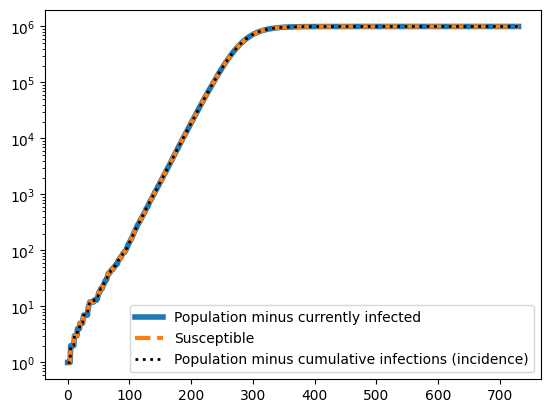

In [5]:
plt.plot(model.nodes.I, lw=4)
N = model.nodes.S + model.nodes.I
plt.plot(N - model.nodes.S, "--", lw=3)
plt.plot(init_inf + np.insert(np.cumsum(model.nodes.incidence[:-1]), 0, 0), ":", lw=2, color="black")
plt.yscale("log")
plt.legend(["Population minus currently infected", "Susceptible", "Population minus cumulative infections (incidence)"])


Introducing stochasticity into a model can result in more than just noise around a mean trajectory, and this simple model is a great example. In the early stages of the outbreak, the infection count is low, and the timing of those first few infections dictates when the logistic growth really takes off.  This appears as a random time-shift in the entire outbreak trajectory.    To illustrate this phenomenon, the below plot shows the model output, the expected logistic growth curve, and the expected logistic growth curve fit to the model with one free parameter -  an offset $t_0$.  The resulting plot should show good concordance between the model output and the expected logistic equation with the known model inputs $\beta$ and population.
The goodness of this fit could be turned into a strict pass/fail test down the line.

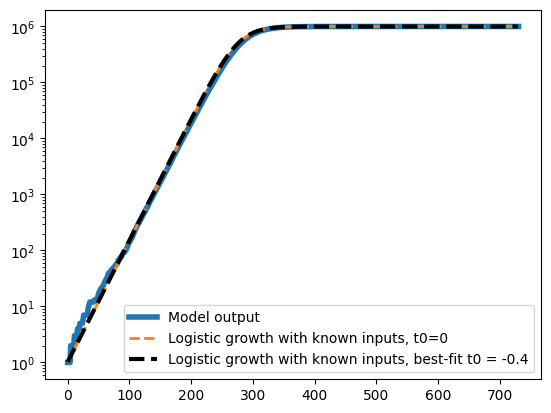

In [6]:
def SI_logistic(t, beta, size, t0):
    return size / (1 + (size - 1) * np.exp(-beta * (t - t0)))


plt.plot(model.nodes.I, lw=4)

t = np.arange(model.params.nticks)


def objective(t0):
    return np.sum((1 - SI_logistic(t, model.params.beta, pop, t0) / np.squeeze(model.nodes.I[1:])) ** 2)


result = minimize(objective, x0=10)
t0_opt = result.x[0]

plt.plot(t, SI_logistic(t, model.params.beta, pop, 0), "--", lw=2)
plt.plot(t, SI_logistic(t, model.params.beta, pop, t0_opt), "--", lw=3, color="k")
plt.yscale("log")
plt.legend(["Model output", "Logistic growth with known inputs, t0=0", f"Logistic growth with known inputs, best-fit t0 = {t0_opt:.1f}"])

## Scientific testing
Finally, we run the model for a range of $\beta$  parameters, we freely fit the model output to the logistic equation, and we compare the known input parameters against the parameters fitted from output.  

Because we are approximating continuously compounding growth by discrete-time compounding growth, we should expect the fitted $\beta$  to consistently be slightly underestimated relative to the true $\beta$ , with the relative difference growing as $\beta$  gets larger.   

In the future, we could probably compute the expected error from this approximation.  But for now, to make this a pass-fail test, we will raise a flag if the fitted $\beta$ is more than 5% different than the known $\beta$.
 

In [7]:
%%capture
nticks = 730
t = np.arange(730)
pop = 1e5

seeds = list(range(10))
betas = [0.01 * i for i in range(1, 11)]
output = pd.DataFrame(columns=["seed", "beta", "cases", "fitted_beta", "fitted_size", "fitted_t0"])

# scenario = pd.DataFrame(data=[["homenode", pop, "47°36′35″N 122°19′59″W"]], columns=["name", "population", "location"])
scenario = grid(M=1,N=1, node_size_km=10, population_fn=lambda x, y:  pop,  origin_x=latitude, origin_y=longitude)
scenario["S"] = scenario.population - init_inf
scenario["I"] = init_inf

for seed, beta in zip(seeds, betas):
    parameters = PropertySet({"seed": seed, "nticks": nticks, "verbose": True, "beta": beta})
    model = SI.Model(scenario, parameters)
    model.components = [
        SI.Susceptible(model),
        SI.Infected(model),
        SI.Transmission(model),
    ]
    # seed_infections_randomly_SI(model, ninfections=1)
    model.run()
    cases = [model.nodes.I[i][0] for i in range(nticks)]
    popt, pcov = curve_fit(SI_logistic, t, cases, p0=[0.05, 1.1e5, 1])

    output = pd.concat(
        [
            output,
            pd.DataFrame.from_dict(
                {
                    "seed": seed,
                    "beta": beta,
                    "cases": [np.array(cases)],
                    "fitted_beta": popt[0],
                    "fitted_size": popt[1],
                    "fitted_t0": popt[2],
                }
            ),
        ],
        ignore_index=True,
    )

Text(0, 0.5, 'Relative error in fitted beta')

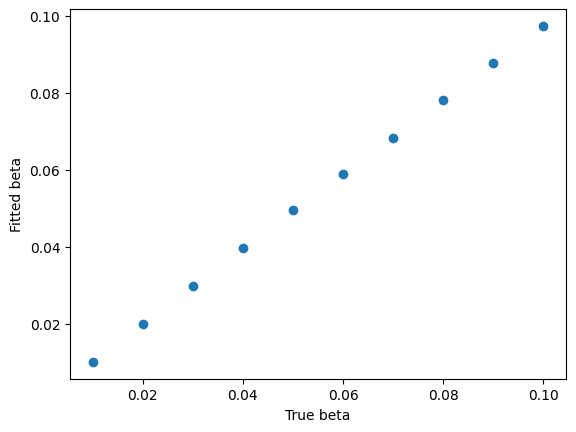

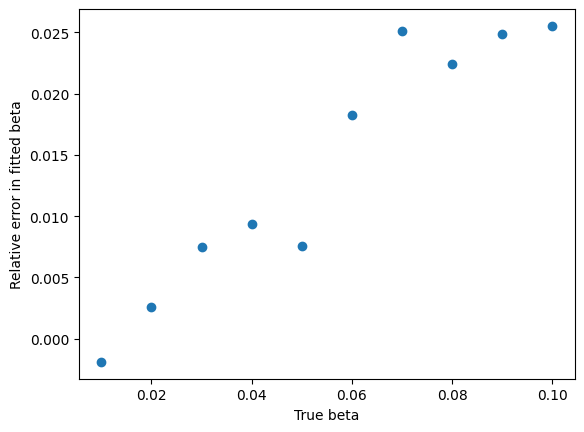

In [8]:
plt.plot(output["beta"], output["fitted_beta"], "o")
plt.xlabel("True beta")
plt.ylabel("Fitted beta")
plt.figure()
plt.plot(output["beta"], (output["beta"] - output["fitted_beta"]) / output["beta"], "o")
plt.xlabel("True beta")
plt.ylabel("Relative error in fitted beta")

In [9]:
print(
    "All fitted beta are within 5% of known beta: " + str(np.all(np.abs((output["beta"] - output["fitted_beta"]) / output["beta"]) < 0.05))
)

All fitted beta are within 5% of known beta: True
